In [8]:
pip install pandas scikit-learn numpy


In [9]:
import pandas as pd

In [4]:
 #Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/Spotify_content_based_rec


/content/drive/MyDrive/Spotify_content_based_rec


In [10]:
#Importing the dataset and choosing limited columns that I feel would best contribute to the model
df = pd.read_csv('spotify_data_12_20_2023.csv')
df = df.filter(['album_id','artists','track_id','track_name','acousticness','danceability','energy','tempo','speechiness'],axis=1)
print(df)

<ipython-input-10-aaab8662d34e>:2: DtypeWarning: Columns (25,26,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('spotify_data_12_20_2023.csv')


                      album_id                         artists  \
0       4zH8bbEjLe0Gdbv2FVLjnK                          ['AB']   
1       4zH8bbEjLe0Gdbv2FVLjnK              ['AB', '22nd Jim']   
2       4zH8bbEjLe0Gdbv2FVLjnK                 ['AB', 'Veeze']   
3       4zH8bbEjLe0Gdbv2FVLjnK                          ['AB']   
4       4zH8bbEjLe0Gdbv2FVLjnK                          ['AB']   
...                        ...                             ...   
375136  1MPAXuTVL2Ej5x0JHiSPq8                ['Taylor Swift']   
375137  6fyR4wBPwLHKcRtxgd4sGh                ['Taylor Swift']   
375138  7mzrIsaAjnXihW3InKjlC3                ['Taylor Swift']   
375139  11gfxXxJPd3j6sdWUyEA5S  ['Taylor Swift', 'Ed Sheeran']   
375140  19O46pvAPG1Xg6fxAuSU5F                ['Taylor Swift']   

                      track_id  \
0       5JucnTkqh8uCZGggL1xxvv   
1       4VWrKNG3ssyZeboTgQ7Kj1   
2       6JsVrTLJPSOSpgJSnZyfSK   
3       7pZpw1xJWIavCUGqXPPriP   
4       0ylqwc3gcJdJotKd4SfMiu   
...

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'speechiness'}>, <Axes: >]], dtype=object)

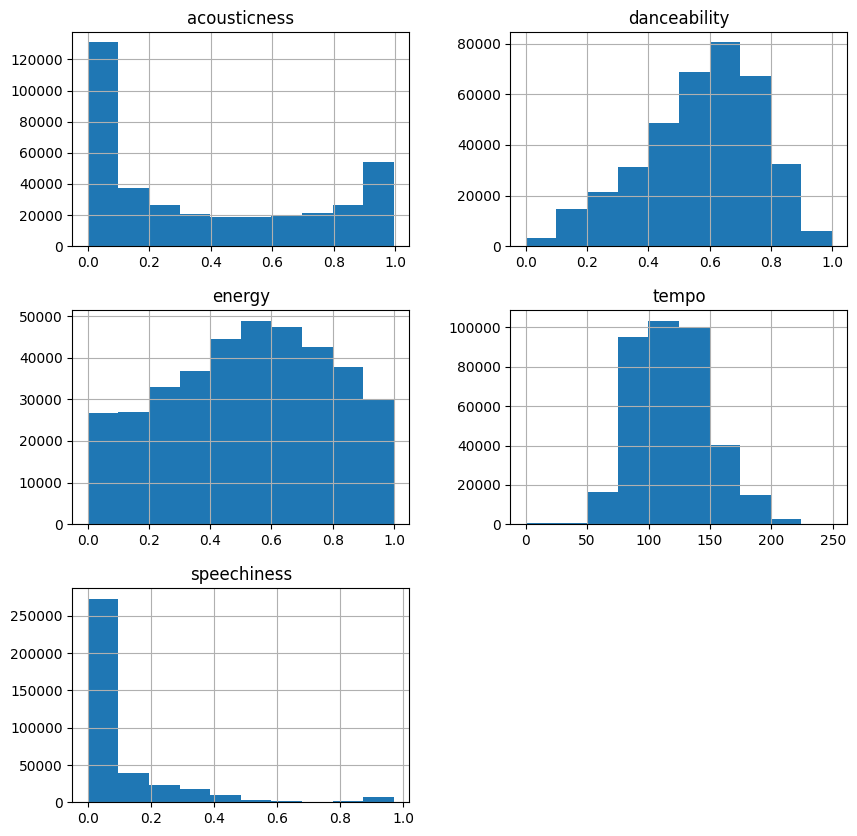

In [ ]:
df.hist(figsize=(10,10))

In [38]:
#basic data cleansing- Null removal
print(df[['danceability','acousticness','tempo','energy','speechiness']].isnull().sum())
df = df.dropna(subset=['danceability','acousticness','tempo','energy','speechiness'])

danceability    0
acousticness    0
tempo           0
energy          0
speechiness     0
dtype: int64


In [39]:
#feature selection
from sklearn.preprocessing import MinMaxScaler

features = df[['danceability','acousticness','tempo','energy','speechiness']]
autoefeatures = features.copy() #features for autoencoder


#Normalizing the features
scalar = MinMaxScaler()
features = scalar.fit_transform(features)
autoefeatures = scalar.fit_transform(autoefeatures)
print(features)

[[0.62262262 0.03062249 0.29084946 0.554      0.42680412]
 [0.8998999  0.01124498 0.4072558  0.701      0.14226804]
 [0.78278278 0.08182731 0.40007136 0.716      0.39381443]
 ...
 [0.58958959 0.00492972 0.45296438 0.805      0.03020619]
 [0.58158158 0.12449799 0.32092628 0.469      0.06402062]
 [0.65465465 0.06526104 0.43319515 0.405      0.03680412]]


In [40]:
#using cosine distance
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(scaled_features)

NearestNeighbors(metric='cosine')

In [49]:
## Get the feature values of the target song (e.g., first song)

target_song = scaled_features[5]
target_song = target_song.reshape(1,-1)

# Find the nearest neighbors
distances, indices = knn.kneighbors(target_song)

print("target song:",df.iloc[5][3])
# Display the similar songs
print("Similar songs:")


for i, index in zip(indices[0], distances[0]):
  print(df.iloc[i])

target song: Decisions
Similar songs:
album_id        4zH8bbEjLe0Gdbv2FVLjnK
artists                         ['AB']
track_id        33prXoje4bkggcsVOP6IT6
track_name                   Decisions
acousticness                    0.0218
danceability                     0.867
energy                            0.61
tempo                          100.967
speechiness                      0.327
Name: 5, dtype: object
album_id           6VFxPplP9ER8fIXaalVar6
artists                ['Anthony Medina']
track_id           1gG7Tz6Ft2PewtVmdu1HZQ
track_name      El Nesquick Y El Macronik
acousticness                        0.112
danceability                        0.799
energy                              0.589
tempo                             105.396
speechiness                        0.0487
Name: 189452, dtype: object
album_id                    6C3ZIb8IV4oh1HEyd52o80
artists         ['YG', 'Tyga', '21 Savage', 'BIA']
track_id                    0yJCj7knf2cOXP1zzZnzkw
track_name       Run (Feat. T

<ipython-input-49-66d3892c7d12>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("target song:",df.iloc[5][3])


# **Auto Encoders Implementatation**

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
#Define autoencoder
input_dim = autoefeatures.shape[1]
encoding_dim = 16
print(input_dim)

5


In [43]:
from keras.layers import Input, Dense
from keras.models import Model

In [44]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
latent_layer = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(latent_layer)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Training the Autoencoder

In [45]:
autoencoder.fit(autoefeatures, autoefeatures, epochs=30, batch_size=128, shuffle = True)

Epoch 1/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0411
Epoch 2/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0071
Epoch 3/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0042
Epoch 4/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0031
Epoch 5/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0025
Epoch 6/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022
Epoch 7/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0021
Epoch 8/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0020
Epoch 9/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0019
Epoch 10/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0019
Epoch 11/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0018
Epoch 12/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018
Epoch 13/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0018
Epoch 14/30
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0017
Epoch 15/30
2925/2925 ━━━━━━

In [46]:
encoder = Model(input_layer, latent_layer)
latent_features = encoder.predict(autoefeatures)
print(latent_features)

11699/11699 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
[[0.        3.785339  1.3414007 ... 2.708964  0.        3.3881066]
 [0.        4.207565  1.5103279 ... 2.6976616 0.        3.034602 ]
 [0.        4.305955  1.5997827 ... 2.8655872 0.        3.6211612]
 ...
 [0.        3.9416668 1.6269072 ... 2.1186254 0.        2.3259149]
 [0.        3.1867228 1.8007598 ... 2.183452  0.        2.417781 ]
 [0.        3.3208313 1.6848081 ... 2.462207  0.        2.6171534]]


Recommending similar songs

In [47]:
def rec(input_song_index,k=5):
  input_song = latent_features[input_song_index].reshape(1,-1)
  similarities = cosine_similarity(input_song, latent_features).flatten()
  similar_indices = similarities.argsort()[-k:][::-1]
  return df.iloc[similar_indices]

In [48]:
recommended_songs = rec(5,k=5)
print(recommended_songs)

                      album_id                                     artists  \
5       4zH8bbEjLe0Gdbv2FVLjnK                                      ['AB']   
357128  3N7agGkKrdlEHBrzSDTNmG  ['Snoop Dogg', 'Nipsey Hussle', 'Problem']   
147489  6kGF8sJ5QLUbT9Ba2rChiB                                  ['Breezy']   
16984   4k3kQkBYpHkawRIi0Rt8E6                             ['Redd Velvet']   
105016  4PF5QpHfSZ8VEFep1N1ZZM                                ['MaccMall']   

                      track_id     track_name  acousticness  danceability  \
5       33prXoje4bkggcsVOP6IT6      Decisions       0.02180         0.867   
357128  4ruc7Nwc3AIIt7oPqnYMHS    Upside Down       0.00301         0.869   
147489  1JwnintUuyrzXi0REKlt6R       Free Rio       0.01050         0.848   
16984   3GQYSyxBb11jgIo0N4E28D            And       0.00138         0.823   
105016  1sXCQHKArenHEHQVUlrqpD  Off The Blocc       0.00326         0.855   

        energy    tempo  speechiness  
5        0.610  100.967      